In [1]:

from torchsummary import summary
import hiddenlayer as hl
import time

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import  datasets
import cv2


import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torch.optim import *
import torch.nn as nn


import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms



# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++Device configuration++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#################################
print('Device:     -----------', device)
################################

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++配置参数+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
torch.manual_seed(4)  # 设置随机数种子，确保结果可重复
num_kernel= 16
n_epoch =1000# 训练次数
valid_n_epoch =1000
batch_size =  128# 批处理大小    280-28：取40
test_batch_size = 1
learning_rate = 0.0001  # 学习率
bn_momentum = 0.1        #     ,momentum= bn_momentum    默认值为0.1
mini_batch=100
loss_func = nn.L1Loss()

# E:\DATA\data_v3\128\train\g1

# train_images_dir = 'E:/DATA/data_v3/128/train/g1/'  # /G_T_IMG/1_001_7_A_1.png
# train_labels_dir = 'E:/DATA/data_v3/128/train/gt/'


train_images_dir = 'E:/DATA/data_v3/10000xin/train/g1/'  # /G_T_IMG/1_001_7_A_1.png
train_labels_dir = 'E:/DATA/data_v3/10000xin/train/gt/'
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++数据加载以及预处理++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++






class DCT_Dataset(Dataset):
    """Class for getting data as a Dict
    Args:
        images_dir = path of input images
        labels_dir = path of labeled images
        transformI = Input Images transformation (default: None)
        transformM = Input Labels transformation (default: None)
    Output:
        sample : Dict of images and labels"""

    def __init__(self, images_dir, labels_dir, transformI=None, transformL=None):


        self.images_dir = images_dir
        self.images_name_list = os.listdir(self.images_dir)
        self.labels_dir = labels_dir
        self.labels_name_list = os.listdir(self.labels_dir)
        self.transformL = transformL
        self.transformI = transformI

        if self.transformI:
            self.transform_images = self.transformI
        else:
            self.transform_images =transforms.Compose([
#                                                             transforms.Resize(280),
                                                            transforms.Grayscale(1),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.5],
                                                                                 std=[0.5])
                                                            ])


         
            self.transform_labels = transforms.Compose([
#                                                             transforms.Resize(128),
                                                            transforms.Grayscale(1),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.5],
                                                                                 std=[0.5])
                                                            ])
    def __getitem__(self, idx):
        images_item_name_list = self.images_name_list[idx]   # self.images_name_list[idx]是一个列表，每一行都是一张图片的名字。
        images_item_path = os.path.join(images_dir+images_item_name_list)  #  每张图片的绝对路径
        images = Image.open( images_item_path)    #  读取每张图片
        images = self.transform_images(images)

        labels_item_name_list = self.labels_name_list[idx]
        labels_name_path = os.path.join(labels_dir + labels_item_name_list)
        labels = Image.open(labels_name_path)
        labels = self.transform_labels(labels)

        return images,labels

    def __len__(self):
        return len(self.images_name_list)     #找到图片名字列表的长度就好了
        # return len(self.labels_name_list)

images_dir = train_images_dir
labels_dir = train_labels_dir

train_Dataset = DCT_Dataset(images_dir,labels_dir)

 #数据加载
train_loader = torch.utils.data.DataLoader(dataset=train_Dataset,
                                           batch_size=batch_size,
                                           shuffle=True
                                        )
######################################
# Checking the dataset ---G_T_IMG
for images, labels in train_loader:  
    print('\n\n train_data\n-------------------------\nG_1  :', images.shape)
    print('G_T  :', labels.shape)
    break
######################################




# images_dir = test_images_dir
# labels_dir = test_labels_dir

# test_Dataset = DCT_Dataset(images_dir,labels_dir)

#  #数据加载
# test_loader = torch.utils.data.DataLoader(dataset=test_Dataset,
#                                            batch_size=test_batch_size,
#                                            shuffle=True
#                                         )
# ######################################
# # Checking the dataset ---G_T_IMG
# for images, labels in test_loader:  
#     print('\n\n\n test_data \n-------------------------\nG_1  :', images.shape)
#     print('G_T  :', labels.shape)
#     break
# ######################################

Device:     ----------- cuda


 train_data
-------------------------
G_1  : torch.Size([128, 1, 128, 128])
G_T  : torch.Size([128, 1, 48, 48])


In [2]:
###++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++彩色； 三通道输入-输出  ；280*280  DEEP_PET原论文复现


class DEEP_DCT(nn.Module):
    def __init__(self, num_classes=10):
        super(DEEP_DCT, self).__init__()

        """  
        Conv2d(卷积核)中
            in_channels ，就是本次卷积输入图像的feather  map张数，也就是卷积核的深度。
            out_channels ，取决于卷积核的数量
            out_channels要跟.BatchNorm2d的输入参数要一致。
            
            例子：  **注意 m 就理解了
            nn.Conv2d(in_channels=1, out_channels =m , kernel_size=7, stride=1,padding=3),
            nn.BatchNorm2d(m),
            nn.ReLU(),
            nn.Conv2d(m, 32, kernel_size=7, stride=1 ,padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
        """

        # +++++++++++++++++++++++++++++++++++++++++++++++++ENCODER++++++++++++++++++++++++++++++++++++++++++++++++++++++
        self.encoder_black = nn.Sequential(

            # A+A            模块——1       layer  1-6 
            nn.Conv2d(in_channels=1, out_channels =32, kernel_size=7, stride=1,padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=7, stride=1 ,padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # BS2+B          模块——2       layer  7-12
            nn.Conv2d(32, 64, kernel_size=5, stride=2,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # BS2+B+B        模块——3      layer  13-21
            nn.Conv2d(64, 128, kernel_size=5, stride=2,padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1,padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1,padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # CS2+C+C        模块——4      layer  22-30
            nn.Conv2d(128, 256, kernel_size=3, stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),            
            
            # CS2+C+C(尺寸变了)    模块——5      layer  31-39
            nn.Conv2d(256, 512, kernel_size=3, stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),         
        
            # c+c+c+c+c            模块——6     layer  40-54
            nn.Conv2d(512,1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024,1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024,1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            

            # c+c+c               模块——7     layer  55-63
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        
        )
#         # +++++++++++++++++++++++++++++++++++++++++++++++++decoder++++++++++++++++++++++++++++++++++++++++++++++++++++++
        self.decoder_black = nn.Sequential(
#            上采样nn.UpsamplingBilinear2d样例    http://codingdict.com/sources/py/torch.nn/8376.html
            

            # D               模块——8     layer  64-73
           #  nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2) ),     #上采样
            nn.UpsamplingBilinear2d(size=(24, 24)),                                # 上采样 scale_factor=2
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            
            # D                模块——9     layer  74-83
            # nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2)),   #上采样
            nn.UpsamplingBilinear2d(size=(32, 32)),                                # 上采样      size=(140, 140)
            nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            
            # 上+C+C           模块——10    layer  91-95
            # nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2)),    #上采样
            nn.UpsamplingBilinear2d(size=(40, 40)),                                # 上采样      size=(140, 140)
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 上+C+C+ c3s1(filter)
            # nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2)),    # 上采样
            nn.UpsamplingBilinear2d(size=(48, 48)),                               # 上采样
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),

        
            ) 

    def forward(self, x):
        out = self.encoder_black(x)
        out = self.decoder_black(out)
        return out


ENCO_DECO = DEEP_DCT()
ENCO_DECO = ENCO_DECO.to(device)


#####################################
# model                   #可以打印出来网络的结构
summary(ENCO_DECO, input_size=(1,128,128))
# hl.build_graph(model,torch.zeros([1,1,280,280]).cuda())     #可能是pytorch版本太高的问题
#####################################


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,600
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]          50,208
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          51,264
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]         102,464
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]         204,928
      BatchNorm2d-14          [-1, 128,

start
epoch [1/1000], loss:0.206945
epoch [2/1000], loss:0.041122
epoch [3/1000], loss:0.056645
epoch [4/1000], loss:0.041073
epoch [5/1000], loss:0.038966
epoch [6/1000], loss:0.039594
epoch [7/1000], loss:0.031240
epoch [8/1000], loss:0.050590
epoch [9/1000], loss:0.038702
epoch [10/1000], loss:0.041115
epoch [11/1000], loss:0.044837
epoch [12/1000], loss:0.040717
epoch [13/1000], loss:0.033288
epoch [14/1000], loss:0.037243
epoch [15/1000], loss:0.039867
epoch [16/1000], loss:0.039100
epoch [17/1000], loss:0.043339
epoch [18/1000], loss:0.033880
epoch [19/1000], loss:0.035683
epoch [20/1000], loss:0.034488
epoch [21/1000], loss:0.048460
epoch [22/1000], loss:0.032314
epoch [23/1000], loss:0.037252
epoch [24/1000], loss:0.037098
epoch [25/1000], loss:0.028650
epoch [26/1000], loss:0.038814
epoch [27/1000], loss:0.036507
epoch [28/1000], loss:0.028421
epoch [29/1000], loss:0.025191
epoch [30/1000], loss:0.027051
epoch [31/1000], loss:0.033359
epoch [32/1000], loss:0.030607
epoch [33/1

epoch [516/1000], loss:0.003884
epoch [517/1000], loss:0.003699
epoch [518/1000], loss:0.004579
epoch [519/1000], loss:0.003389
epoch [520/1000], loss:0.003403
epoch [521/1000], loss:0.003402
epoch [522/1000], loss:0.003415
epoch [523/1000], loss:0.002972
epoch [524/1000], loss:0.004396
epoch [525/1000], loss:0.003439
epoch [526/1000], loss:0.003545
epoch [527/1000], loss:0.003607
epoch [528/1000], loss:0.003031
epoch [529/1000], loss:0.003408
epoch [530/1000], loss:0.003065
epoch [531/1000], loss:0.002571
epoch [532/1000], loss:0.003037
epoch [533/1000], loss:0.003469
epoch [534/1000], loss:0.002276
epoch [535/1000], loss:0.003748
epoch [536/1000], loss:0.002494
epoch [537/1000], loss:0.002731
epoch [538/1000], loss:0.003351
epoch [539/1000], loss:0.003439
epoch [540/1000], loss:0.003226
epoch [541/1000], loss:0.002237
epoch [542/1000], loss:0.003903
epoch [543/1000], loss:0.005205
epoch [544/1000], loss:0.007537
epoch [545/1000], loss:0.003037
epoch [546/1000], loss:0.002674
epoch [5

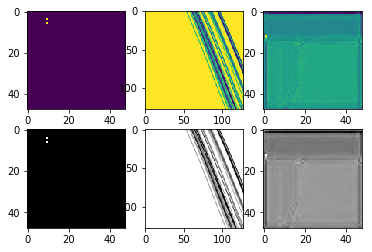

In [3]:




# 尾部
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
lr_list = []
# model = ENCO_DECO
min_loss = 100000 # 随便设置一个比较大的数

loss_func = loss_func
optimizer = torch.optim.Adam(ENCO_DECO.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[20,50],gamma = 0.5)#-----------------------------
start_time = time.time()

print('start')
for i in range(n_epoch):

    for G1_IMG,G_T_IMG in train_loader:

        G_T_IMG = G_T_IMG.to(device)     #变量封装   #ground_truth
        G1_IMG = G1_IMG.to(device)       #网络输入图像input
        optimizer.zero_grad()      #梯度置零，不置零算的不准确
        output = ENCO_DECO(G1_IMG)#这里的 output是整个网络的输出

        loss = loss_func(output, G_T_IMG)                       #计算损失函数：网络输出（output）跟ground_truth（image）之间
        loss.backward()  #反向传播，参数的梯度计算
        optimizer.step() #更新权重值
    #             scheduler.step()#-------------------------------------------------------
    #             lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])#---------------------------------------

    print('epoch [{}/{}], loss:{:.6f}'
          .format(i + 1, n_epoch, loss.data.item()))
                                   #-------------------------------------------------------
    
    if i % 200 == 0:
        torch.save(ENCO_DECO,'ENCO_DECO31_'+'%d.pkl' % (i))
    elif i > 700:
        if loss < min_loss:
            min_loss = loss
            torch.save(ENCO_DECO,'ENCO_DECO31_'+'best.pkl')
            print('    best model comes from : '+'epoch %d' % (i))
                                   #-------------------------------------------------------
print('Total Training Time: %.6f min' % ((time.time() - start_time)/60))     #打印时间
# plt.plot(range(n_epoch),lr_list,color = 'r')#------------------------------------------
                                                                           
ground_truth = G_T_IMG[0].cpu()                                            
input_images = G1_IMG[0].cpu()                                             
output = output[0].cpu()                                                   
G_T_IMG = ground_truth.data.numpy()                                        
G1_IMG = input_images.data.numpy()                                         
O_IMG = output.data.numpy()                                                
plt.figure('DEEP-DCT')                                                     
plt.subplot(231)                                                           
plt.imshow(G_T_IMG[0])  # ground_truth(label)                               
                                                                           
plt.subplot(232)                                                           
plt.imshow(G1_IMG[0])  # input_images                                      
                                                                           
plt.subplot(233)                                                           
plt.imshow(O_IMG[0])  # output_images                                      
                                                                           
plt.subplot(234)                                                           
plt.imshow(G_T_IMG[0], cmap='gray')  # ground_truth(label)                 
plt.subplot(235)                                                           
plt.imshow(G1_IMG[0], cmap='gray')  # input_images                         
plt.subplot(236)                                                           
plt.imshow(O_IMG[0], cmap='gray')  # output_images                         
plt.show()                                                                 
# print(label[0])                                                          


#学习率衰减             https://www.jianshu.com/p/9643cba47655
# gpu从这里参考        https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-deconv-nopool.ipynb
#书上的自编码代码     https://github.com/xiaobaoonline/pytorch-in-action/blob/master/chapter6_%E5%B5%8C%E5%85%A5%E4%B8%8E%E8%A1%A8%E7%A4%BA%E5%AD%A6%E4%B9%A0/denoise_autoencoder.py#L163



In [4]:
# torch.save(ENCO_DECO, 'ENCO_DECO19.pkl')  # 保存整个网络

epoch [1/1000], loss:0.006969
epoch [1/1000], total_valid_loss:0.006969
Total test time: 0.004472 min


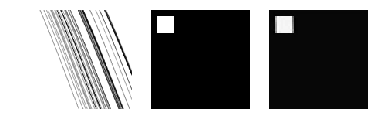

In [26]:

train_images_dir = 'E:/DATA/data_v3/5000xin/test/g1/'  # /G_T_IMG/1_001_7_A_1.png
train_labels_dir = 'E:/DATA/data_v3/5000xin/test/gt/'
valid_images_dir = train_images_dir  # /G_T_IMG/1_001_7_A_1.png
valid_labels_dir =train_labels_dir


images_dir = valid_images_dir
labels_dir = valid_labels_dir

valid_Dataset = DCT_Dataset(images_dir,labels_dir)

 #数据加载
valid_loader = torch.utils.data.DataLoader(dataset=valid_Dataset,
                                           batch_size=test_batch_size,
                                           shuffle=True
                                        )
# ######################################
# # Checking the dataset ---G_T_IMG
# for images, labels in test_loader:  
#     print('\n\n\n test_data \n-------------------------\nG_1  :', images.shape)
#     print('G_T  :', labels.shape)
#     break
# ######################################
    #######################################################
    #Validation Step
    #######################################################
# ENCO_DECO.eval()
# torch.no_grad() #to increase the validation process uses less memory
start_time = time.time()
for i in range(1):
    ENCO_DECO.eval()
    torch.no_grad() #to increase the validation process uses less memory
    for x1, y1 in valid_loader:
        x1, y1 = x1.to(device), y1.to(device)
#         ENCO_DECO.eval()
#         torch.no_grad() #to increase the validation process uses less memory

        y_pred1 =  ENCO_DECO(x1)
        loss = loss_func(y_pred1, y1)     # Dice_loss Used
        valid_loss = loss.item() * x1.size(0)
#         valid_loss += loss.item() * x1.size(0)
#         x_size1 = lossL.item() * x1.size(0)
    print('epoch [{}/{}], loss:{:.6f}'
          .format(i + 1, valid_n_epoch, loss.data.item()))
    print('epoch [{}/{}], total_valid_loss:{:.6f}'
          .format(i + 1, valid_n_epoch, valid_loss))
    
print('Total test time: %.6f min' % ((time.time() - start_time)/60))     #打印时间

                                                                           
ground_truth = y1[0].cpu()                                            
input_images = x1[0].cpu()                                             
output = y_pred1[0].cpu()                                                   
G_T_IMG = ground_truth.data.numpy()                                        
G1_IMG = input_images.data.numpy()                                         
O_IMG = output.data.numpy()  
                                      
                                                                           
plt.subplot(235)                                                           
plt.imshow(G_T_IMG[0], cmap='gray')  # ground_truth(label)    
plt.axis('off')

plt.subplot(234)                                                           
plt.imshow(G1_IMG[0], cmap='gray')  # input_images   
plt.axis('off')

plt.subplot(236)                                                           
plt.imshow(O_IMG[0], cmap='gray')  # output_images  
plt.axis('off')

plt.show()                                                                 
# print(label[0])        



import matplotlib  
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,savefig


epoch [1/1000], loss:0.084088
epoch [1/1000], total_valid_loss:0.084088
Total test time: 0.004272 min


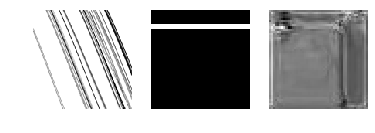

In [52]:
# 上面是训练完直接开始测试，这个是训练完，保存模型后，在加载。得出测试结果
import torch

ENCO_DECO_TEST = torch.load('ENCO_DECO19.pkl')

# train_images_dir = 'E:/DATA/data_v3/in_vivo_test/g1xiaoshu/'  # /G_T_IMG/1_001_7_A_1.png
# train_labels_dir = 'E:/DATA/data_v3/in_vivo_test/gt/'

train_images_dir = 'E:/DATA/data_v3/5000xin/test/g1/'  # /G_T_IMG/1_001_7_A_1.png
train_labels_dir = 'E:/DATA/data_v3/5000xin/test/gt/'
valid_images_dir = train_images_dir  # /G_T_IMG/1_001_7_A_1.png
valid_labels_dir =train_labels_dir


images_dir = valid_images_dir
labels_dir = valid_labels_dir

valid_Dataset = DCT_Dataset(images_dir,labels_dir)

 #数据加载
valid_loader = torch.utils.data.DataLoader(dataset=valid_Dataset,
                                           batch_size=test_batch_size,
                                           shuffle=True
                                        )
# ######################################
# # Checking the dataset ---G_T_IMG
# for images, labels in test_loader:  
#     print('\n\n\n test_data \n-------------------------\nG_1  :', images.shape)
#     print('G_T  :', labels.shape)
#     break
# ######################################
    #######################################################
    #Validation Step
    #######################################################
# ENCO_DECO.eval()
# torch.no_grad() #to increase the validation process uses less memory
start_time = time.time()
for i in range(1):
    ENCO_DECO.eval()
    torch.no_grad() #to increase the validation process uses less memory
    for x1, y1 in valid_loader:
        x1, y1 = x1.to(device), y1.to(device)
#         ENCO_DECO.eval()
#         torch.no_grad() #to increase the validation process uses less memory

        y_pred1 =  ENCO_DECO_TEST(x1)
        loss = loss_func(y_pred1, y1)     # Dice_loss Used
        valid_loss = loss.item() * x1.size(0)
#         valid_loss += loss.item() * x1.size(0)
#         x_size1 = lossL.item() * x1.size(0)
    print('epoch [{}/{}], loss:{:.6f}'
          .format(i + 1, valid_n_epoch, loss.data.item()))
    print('epoch [{}/{}], total_valid_loss:{:.6f}'
          .format(i + 1, valid_n_epoch, valid_loss))
    
print('Total test time: %.6f min' % ((time.time() - start_time)/60))     #打印时间

                                                                           
ground_truth = y1[0].cpu()                                            
input_images = x1[0].cpu()                                             
output = y_pred1[0].cpu()                                                   
G_T_IMG = ground_truth.data.numpy()                                        
G1_IMG = input_images.data.numpy()                                         
O_IMG = output.data.numpy()  
                                      
                                                                           
plt.subplot(235)                                                           
plt.imshow(G_T_IMG[0], cmap='gray')  # ground_truth(label)    
plt.axis('off')

plt.subplot(234)                                                           
plt.imshow(G1_IMG[0], cmap='gray')  # input_images   
plt.axis('off')

plt.subplot(236)                                                           
plt.imshow(O_IMG[0], cmap='gray')  # output_images  
plt.axis('off')

plt.show()                                                                 
# print(label[0])      



In [7]:
torch.cuda.empty_cache()

In [8]:
label=np.array(Image.open("E:/DATA/data_v3/10000xin/test/gt/000023.bmp"))

In [9]:
label.shape

(48, 48)